### Uniformly select 200 examples from original SimpleQA dataset
1. download original SimpleQA dataset from this [link](https://huggingface.co/datasets/basicv8vc/SimpleQA/resolve/main/simple_qa_test_set.csv?download=true)
2. run the following code to select 200 examples uniformly

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

#set random seed for reproducibility
np.random.seed(42)

In [2]:
original_df = pd.read_csv('simple_qa_test_set.csv')

# uniformly sample 200 rows from the original DataFrame
sampled_df = original_df.sample(n=200, random_state=42)
sampled_df.head()

,metadata,problem,answer
2333,"{'topic': 'Art', 'answer_type': 'Number', 'url...",At what age was Ken Noda invited by President ...,20
803,"{'topic': 'Art', 'answer_type': 'Other', 'urls...",Which art dealership did Peter Arrell Browne W...,Knoedler
3113,"{'topic': 'Music', 'answer_type': 'Person', 'u...",What was composer Sigrid Ingeborg Henriette Wi...,Anna Bruun Tordenskjold
3524,"{'topic': 'Geography', 'answer_type': 'Number'...",What is the forest cover area of Madhya Prades...,"77,482.49"
1675,"{'topic': 'TV shows', 'answer_type': 'Person',...",Who kills Daryl Garrs in Happy Valley?,Alison Garrs


### Call LLM APIs to generate uncertain statements using instruction template
Here, we use `build_dataset.py` to generate uncertain statements using LLM APIs. 

In [3]:
# Instruction template
instruction_template = """
You are given a question and its ground-truth answer. Your task is to generate 50 answer sentences that express the same answer using different levels of confidence:

10 with high confidence
10 with moderate confidence
10 with low confidence
10 with lowest confidence
10 with complete uncertainty, reject to reply

The wording should vary across the levels, but all responses should convey the same core answer. Focus on natural and diverse expressions of confidence.

Question: {}
Answer: {}
"""

# llm api keys
llm_api_keys = {
    'gpt': os.getenv('GPT_API_KEY'),
    'gemini': os.getenv('GEMINI_API_KEY'),
    'claude': os.getenv('CLAUDE_API_KEY'),
    'grok': os.getenv('GROK_API_KEY')
}

### Generate 10,000 uncertain statements per LLM
Each LLM can take around 2 hours to generate, you can also use `sampling_response.py` to sample the generated uncertain statements.

In [4]:
from llm_api_handler import gemini_generate, gpt_generate, claude_generate, grok_generate


llm_to_use = 'gemini'  # Change this to 'gpt', 'gemini', 'gemini' or 'grok' as needed
llm_generate = {
    'gpt': gpt_generate, # gpt-4.1
    'gemini': gemini_generate, # gemini-2.5-pro
    'claude': claude_generate, # claude-sonnet-4-20250514
    'grok': grok_generate # grok-3
}[llm_to_use]

# # uncomment to test api
# first_row = sampled_df.iloc[0]
# instruction = instruction_template.format(first_row['problem'], first_row['answer'])
# response = llm_generate(instruction, llm_api_keys[llm_to_use])
# print(response)

# new_df = pd.DataFrame(columns=['problem', 'answer', 'raw_response', 'metadata'])

# for index, row in tqdm(sampled_df.iterrows()):
#     problem = row['problem']
#     answer = row['answer']
#     metadata = row['metadata']
#     instruction = instruction_template.format(problem, answer)
#     text = llm_generate(instruction, api_key=llm_api_keys[llm_to_use])
#     # add the generated text to the new df
#     new_row = {
#         'problem': problem,
#         'answer': answer,
#         'raw_response': text,
#         'metadata': metadata
#     }
#     new_df = new_df._append(new_row, ignore_index=True)
#     # save the new df to csv file
#     new_df.to_csv(f'generated_text_{llm_to_use}.csv', index=False)

### Extract uncertain statements from raw reponse using regex
use interactive code to modify edge cases by running 
`python extract_sentences.py`

### Sample 10,000 uncertain statements from the extracted uncertain statements
Extract selected 2500 examples per LLM and make a new df


In [5]:
import pandas as pd

extracted_df = pd.read_csv(f'all_sentences_by_confidence.csv')

# Save the index of extracted_df as orig_idx
extracted_df = extracted_df.reset_index().rename(columns={'index': 'orig_idx'})

# We want to sample 10000 unique sentences, stratified by confidence level.
# For 'completely uncertain', sample 5% (at least 1), for others, sample uniformly so that total is 10000.
# If there are duplicate sentences, resample to ensure all 10000 are unique.

total_n = 10000
sampled_sentences = set()
sampled_rows = []

# Step 1: Sample 'completely uncertain'
conf_levels = list(extracted_df['confidence'].unique())
completely_uncertain_conf = 'completely uncertain'
other_levels = [c for c in conf_levels if c != completely_uncertain_conf]

conf_df = extracted_df[extracted_df['confidence'] == completely_uncertain_conf]
n_cu = int(len(conf_df) * 0.0628)
n_cu = max(n_cu, 1)
cu_sample = conf_df.sample(n=n_cu, random_state=42)
# Remove duplicates by sentence
cu_sample = cu_sample.drop_duplicates(subset=['sentence'])
sampled_rows.append(cu_sample)
sampled_sentences.update(cu_sample['sentence'].tolist())
completely_uncertain_n = len(cu_sample)

# Step 2: Sample from other levels, ensuring uniqueness
remaining_n = total_n - completely_uncertain_n
n_per_level = remaining_n // len(other_levels)
extra = remaining_n % len(other_levels)

for i, conf in enumerate(other_levels):
    conf_df = extracted_df[extracted_df['confidence'] == conf]
    n = n_per_level + (1 if i < extra else 0)
    # Remove sentences already sampled
    conf_df = conf_df[~conf_df['sentence'].isin(sampled_sentences)]
    # If not enough left, just take all
    n = min(n, len(conf_df))
    # Sample, drop duplicates, and ensure uniqueness
    sampled = pd.DataFrame()
    attempts = 0
    while len(sampled) < n and attempts < 20:
        needed = n - len(sampled)
        # Oversample a bit to account for possible duplicates
        try_sample = conf_df.sample(n=min(needed*2, len(conf_df)), random_state=42+attempts)
        try_sample = try_sample[~try_sample['sentence'].isin(sampled_sentences)]
        try_sample = try_sample.drop_duplicates(subset=['sentence'])
        sampled = pd.concat([sampled, try_sample]).drop_duplicates(subset=['sentence'])
        sampled = sampled.head(n)
        attempts += 1
    sampled_rows.append(sampled)
    sampled_sentences.update(sampled['sentence'].tolist())

# Step 3: Combine and check for uniqueness
sampled_10000_df = pd.concat(sampled_rows, ignore_index=True)
sampled_10000_df = sampled_10000_df.drop_duplicates(subset=['sentence']).reset_index(drop=True)

# If we have less than 10000 due to deduplication, fill up with random unique sentences from the rest
if len(sampled_10000_df) < total_n:
    needed = total_n - len(sampled_10000_df)
    remaining_df = extracted_df[~extracted_df['sentence'].isin(sampled_10000_df['sentence'])]
    fill_sample = remaining_df.drop_duplicates(subset=['sentence']).sample(n=needed, random_state=123)
    sampled_10000_df = pd.concat([sampled_10000_df, fill_sample], ignore_index=True)
    sampled_10000_df = sampled_10000_df.drop_duplicates(subset=['sentence']).reset_index(drop=True)

# Final check
assert sampled_10000_df['sentence'].is_unique
assert len(sampled_10000_df) == 10000

sampled_10000_df['model'].value_counts()

model
grok      2701
gemini    2492
claude    2445
gpt       2362
Name: count, dtype: int64

In [6]:
sampled_10000_df['confidence'].value_counts()

confidence
high                    2375
low                     2375
moderate                2375
lowest                  2375
completely uncertain     500
Name: count, dtype: int64

In [7]:
sampled_10000_df['sentence'].nunique()

10000

In [8]:
sampled_10000_df.to_csv('sampled_10000_sentences.csv')

### Make mturk dataset

In [9]:
# randomly sample 50 rows from the sampled_10000_df
sampled_50_df_for_validation = sampled_10000_df.sample(n=50, random_state=41).reset_index(drop=True)
    
# for each confidence level, we assign a lower bound and a upper bound
confidence_bounds = {
    'completely uncertain': (0, 30),
    'lowest': (10, 50),
    'low': (20, 70),
    'moderate': (40, 90),
    'high': (60, 100)
}
# assign the lower and upper bounds to the sampled_50_df_for_validation
sampled_50_df_for_validation['lower_bound'] = sampled_50_df_for_validation['confidence'].map(lambda x: confidence_bounds[x][0])
sampled_50_df_for_validation['upper_bound'] = sampled_50_df_for_validation['confidence'].map(lambda x: confidence_bounds[x][1])

sampled_50_df_for_validation.to_csv('sampled_50_df_for_validation.csv')

In [10]:
number_of_sentence_per_survey = 100
mturk_df = pd.DataFrame()
sampled_10000_df = sampled_10000_df.sample(frac=1, random_state=42)
# every 100 rows as a row, put the sentence and the index of the corresponding row in the new row
for i in range(0, len(sampled_10000_df), number_of_sentence_per_survey):
    row = {}
    for j in range(number_of_sentence_per_survey):
        if i + j < len(sampled_10000_df):
            row[f'sentence_{j + 1}'] = sampled_10000_df.iloc[i + j]['sentence']
            row[f'index_{j + 1}'] = sampled_10000_df.iloc[i + j]['orig_idx']
    # randomly sample 5 rows from the sampled_50_df_for_validation, call val_sentence_1, val_lower_bound_1, val_upper_bound_1, val_sentence_2, val_lower_bound_2, val_upper_bound_2, val_sentence_3, val_lower_bound_3, val_upper_bound_3, val_sentence_4, val_lower_bound_4, val_upper_bound_4, val_sentence_5, val_lower_bound_5, val_upper_bound_5
    sampled_5_df_for_validation = sampled_50_df_for_validation.sample(n=5).reset_index(drop=True)
    for q in range(5):
        row[f'val_sentence_{q + 1}'] = sampled_5_df_for_validation.iloc[q]['sentence']
        row[f'val_index_{q + 1}'] = sampled_5_df_for_validation.iloc[q]['orig_idx']
        row[f'val_lower_bound_{q + 1}'] = sampled_5_df_for_validation.iloc[q]['lower_bound']
        row[f'val_upper_bound_{q + 1}'] = sampled_5_df_for_validation.iloc[q]['upper_bound']
    mturk_df = pd.concat([mturk_df, pd.DataFrame([row])], ignore_index=False)


mturk_df.to_csv('mturk_tasks.csv', index=False)
mturk_df.head()

,sentence_1,index_1,sentence_2,index_2,sentence_3,index_3,sentence_4,index_4,sentence_5,index_5,...,val_lower_bound_3,val_upper_bound_3,val_sentence_4,val_index_4,val_lower_bound_4,val_upper_bound_4,val_sentence_5,val_index_5,val_lower_bound_5,val_upper_bound_5
0,"I think the Warcraft wiki says 13,000 years, b...",18426,All signs point to Linus Pauling.,23519,The Mediterranean Sea's maximum depth measures...,32909,"To the best of my recollection, it was May 10,...",3716,I believe it was 13 May 2004 when he received ...,611,...,40,90,The evidence suggests Chris Frazer Smith won t...,33366,40,90,It appears that Yanfei Bao went missing on Jul...,31412,40,90
0,September 2014 was exactly when Apple introduc...,37807,I’d say that Hannes Fink’s place of birth is p...,4517,My records indicate that the number is DB12457.,25111,"I'm struggling to find a solid source, but a w...",27287,"I’m not completely confident, but I believe Bu...",5379,...,40,90,"It was possibly 2018, but I'd have to check to...",29226,20,70,The evidence suggests Chris Frazer Smith won t...,33366,40,90
0,The evidence suggests his appointment occurred...,31017,"I’m really not sure, but Zerxus might possibly...",7430,I can't provide a confident answer about the s...,37893,"From what I recall, it was June 21, 2017.",17861,"Off the top of my head, and I could be complet...",22938,...,10,50,"I’m not completely certain, but PSLV-C52 seems...",14278,20,70,"The information I have points towards 1988, th...",28474,20,70
0,"I’m inclined to say June 26, 1958, for her dat...",14928,"Without a doubt, the reveal happened on Septem...",29302,My understanding is that there have possibly b...,12273,It is widely believed that Mahmud Hasan Deoban...,22561,That specific biographical detail is not avail...,24341,...,60,100,It seems Jackson Asiku's birth date is 21 Octo...,32115,40,90,It is a known fact that she graduated with a B...,26954,60,100
0,Pipilotti Rist was honored with the Premio 200...,18555,I suspect the year was 1985.,31029,"I would need to check, but a wild guess would ...",25683,"With very little confidence, I'd guess Robert ...",31985,It was most likely Oliver Purnell.,25063,...,20,70,I’m completely unsure about this and can’t say...,8392,0,30,It is a known fact that she graduated with a B...,26954,60,100


## Finish sampling on Amazon Mechanical Turk platform and collect the results saved in `annotation.csv`
arrange all annotations and saved in `dataset.csv`

In [14]:
import pandas as pd

dataset_df = pd.DataFrame(columns=['orig_idx_in_40000_dataset', 'question', 'ground_truth_answer' 'uncertainty_expression', 'llm_confidence_level', 'source_llm', 'annotater_confidence_score1', 'annotater_confidence_score2', 'annotater_confidence_score3', 'annotater_confidence_score4', 'annotater_confidence_score5'])
sampled_10000_df = pd.read_csv('sampled_10000_sentences.csv')
annotation_df = pd.read_csv('annotation.csv')
orig_idx_anno_pair = {}
for _, row in annotation_df.iterrows():
    for i in range(1, 101):
        orig_idx_col_name = f'Input.index_{i}'
        sent_col_name = f'Input.sentence_{i}'
        anno_col_name = f'Answer.confidence_score_sentence_{i}'
        orig_idx = row[orig_idx_col_name]
        anno_conf = row[anno_col_name]
        if orig_idx not in orig_idx_anno_pair:
            orig_idx_anno_pair[orig_idx] = [anno_conf]
        else:
            orig_idx_anno_pair[orig_idx].append(anno_conf)
            
# save to df
for orig_idx, anno_confs in orig_idx_anno_pair.items():
    new_row = {
        'orig_idx_in_40000_dataset': orig_idx,
        'question': sampled_10000_df.loc[sampled_10000_df['orig_idx'] == orig_idx, 'problem'].values[0],
        'ground_truth_answer': sampled_10000_df.loc[sampled_10000_df['orig_idx'] == orig_idx, 'answer'].values[0],
        'uncertainty_expression': sampled_10000_df.loc[sampled_10000_df['orig_idx'] == orig_idx, 'sentence'].values[0],
        'llm_confidence_level': sampled_10000_df.loc[sampled_10000_df['orig_idx'] == orig_idx, 'confidence'].values[0],
        'source_llm': sampled_10000_df.loc[sampled_10000_df['orig_idx'] == orig_idx, 'model'].values[0],
        'annotater_confidence_score1': anno_confs[0],
        'annotater_confidence_score2': anno_confs[1],
        'annotater_confidence_score3': anno_confs[2],
        'annotater_confidence_score4': anno_confs[3],
        'annotater_confidence_score5': anno_confs[4]
    }
    # Collect new_row dicts in a list, then create DataFrame after the loop
    if 'rows_to_add' not in locals():
        rows_to_add = []
    rows_to_add.append(new_row)
dataset_df = pd.DataFrame(rows_to_add)
    
dataset_df.head()

,orig_idx_in_40000_dataset,question,ground_truth_answer,uncertainty_expression,llm_confidence_level,source_llm,annotater_confidence_score1,annotater_confidence_score2,annotater_confidence_score3,annotater_confidence_score4,annotater_confidence_score5
0,18426,"According to the Warcraft wiki, approximately ...",13000,"I think the Warcraft wiki says 13,000 years, b...",low,GPT-4o,74,9,52,20,74
1,23519,Which scientist received the Roebling Medal th...,Linus Pauling,All signs point to Linus Pauling.,moderate,Gemini-2.5 Pro,73,46,52,71,62
2,32909,What is the maximum depth of the Mediterranean...,5109 m,The Mediterranean Sea's maximum depth measures...,high,Claude Sonnet 4,77,81,57,84,31
3,3716,"What month, day, and year did Laura Toggs and ...",May 10 2023,"To the best of my recollection, it was May 10,...",moderate,Grok-3,84,86,54,72,68
4,611,"What day, month, and year was David Crombie ap...",13 May 2004,I believe it was 13 May 2004 when he received ...,moderate,Grok-3,83,71,53,78,88


In [13]:
dataset_df.to_csv('dataset.csv', index=False)

## Visualization
random show histogram of on uncertain expressions

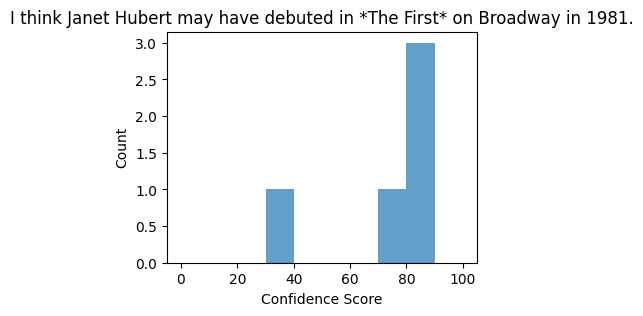

In [29]:
import matplotlib.pyplot as plt

row_idx = np.random.choice(dataset_df.index, size=1)[0]

plt.figure(figsize=(4, 3))
plt.hist(dataset_df.iloc[row_idx][['annotater_confidence_score1', 'annotater_confidence_score2', 'annotater_confidence_score3', 'annotater_confidence_score4', 'annotater_confidence_score5']], bins=np.arange(0, 101, 10), alpha=0.7, label=['Annotator 1', 'Annotator 2', 'Annotator 3', 'Annotator 4', 'Annotator 5'])
plt.title(dataset_df.iloc[row_idx]['uncertainty_expression']) 
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.show()